# Example: 1D Gaussian MLP

Setup: Our goal is to learn a 1D function from samples. The 1D function has 5 Gaussian peaks. Instead of presenting all samples to NN all at once, we have five phases of learning. In each phase only samples around one peak is presented to KAN. We find that KANs can do continual learning thanks to locality of splines.

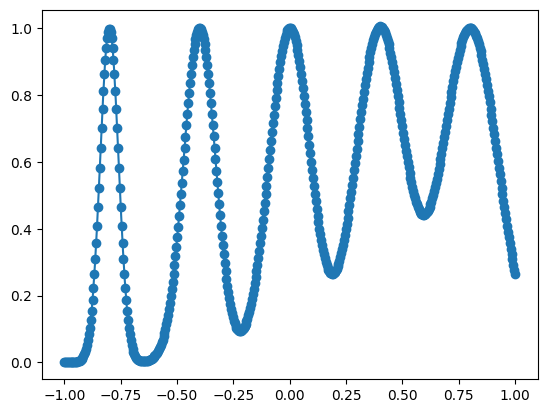

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt


datasets = []

n_peak = 5
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1,1,steps=n_sample)

x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2+0.5)
x_sample = torch.stack([torch.linspace(-1/n_peak,1/n_peak,steps=n_num_per_peak)+center for center in x_centers]).reshape(-1,)

y = 0.
i=1
for center in x_centers:
    y += torch.exp(-(x_grid-center)**2*(300/i))
    i += 2
    
y_sample = 0.
i=1
for center in x_centers:
    y_sample += torch.exp(-(x_sample-center)**2*(300/i))
    i += 2
    
plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())

Sequentially prensenting different peaks to MLP

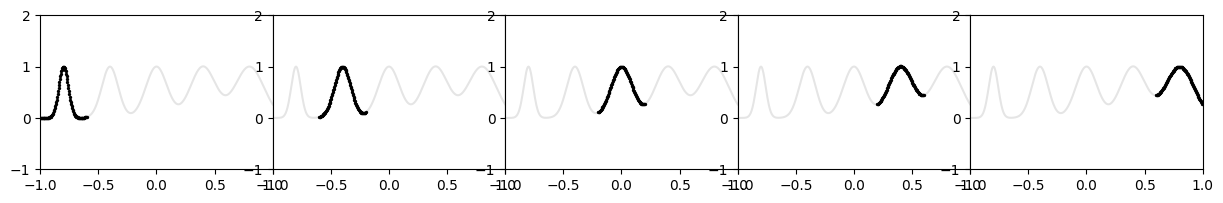

In [2]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.scatter(x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), color="black", s=2)
    plt.xlim(-1,1)
    plt.ylim(-1,2)
plt.savefig("/home/thealch3mist/University/Thesis/KANT_Forget/Figures/toy_data_input.png")

Training MLP

In [11]:
import sys

class MLP(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, hidden_layers):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.hidden_layers = hidden_layers
        self.layers = torch.nn.ModuleList()
        
        # Input layer
        self.layers.append(torch.nn.Linear(input_size, hidden_size))
        
        # Hidden layers
        for _ in range(hidden_layers):
            self.layers.append(torch.nn.Linear(hidden_size, hidden_size))
        
        # Output layer
        self.layers.append(torch.nn.Linear(hidden_size, output_size))
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)  # No activation on the output layer for regression
        return x

ys = []

model = MLP(input_size=1, output_size=1, hidden_size=256, hidden_layers=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for group_id in range(n_peak):
    dataset = {}

    dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None].to(device)
    dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None].to(device)
    dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None].to(device)
    dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None].to(device)
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        y_pred = model(dataset['train_input'])
        # print(dataset['train_input'])
        loss = criterion(y_pred, dataset['train_label'])
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Group {group_id} Epoch {epoch} Loss: {loss.item()}")
    model.eval()
    with torch.no_grad():
        model.eval()
        y_pred = model(x_grid[:,None].to(device))
        # print(y_pred[50])
        ys.append(y_pred.cpu().detach().numpy()[:,0])
        # loss = torch.nn.MSELoss()(y_pred, dataset['test_label'])
        print(f"Initial Loss: {loss.item()}")
    
    

cuda
Group 0 Epoch 0 Loss: 0.1369849294424057
Group 0 Epoch 100 Loss: 0.02555304765701294
Group 0 Epoch 200 Loss: 0.016831833869218826
Group 0 Epoch 300 Loss: 0.005315510090440512
Group 0 Epoch 400 Loss: 0.0010187724838033319
Group 0 Epoch 500 Loss: 0.0004422232450451702
Group 0 Epoch 600 Loss: 0.0001773721887730062
Group 0 Epoch 700 Loss: 0.00010125239350600168
Group 0 Epoch 800 Loss: 6.382893479894847e-05
Group 0 Epoch 900 Loss: 5.0246657337993383e-05
Initial Loss: 4.706491745309904e-05
Group 1 Epoch 0 Loss: 0.3086008131504059
Group 1 Epoch 100 Loss: 0.0037760459817945957
Group 1 Epoch 200 Loss: 0.0030294093303382397
Group 1 Epoch 300 Loss: 0.0021654984448105097
Group 1 Epoch 400 Loss: 0.0015311826718971133
Group 1 Epoch 500 Loss: 0.0010262536816298962
Group 1 Epoch 600 Loss: 0.0005873604095540941
Group 1 Epoch 700 Loss: 0.0003873415698762983
Group 1 Epoch 800 Loss: 0.00026872201124206185
Group 1 Epoch 900 Loss: 0.00019496858294587582
Initial Loss: 0.00014721788465976715
Group 2 Epoc

Prediction of KAN after each stage

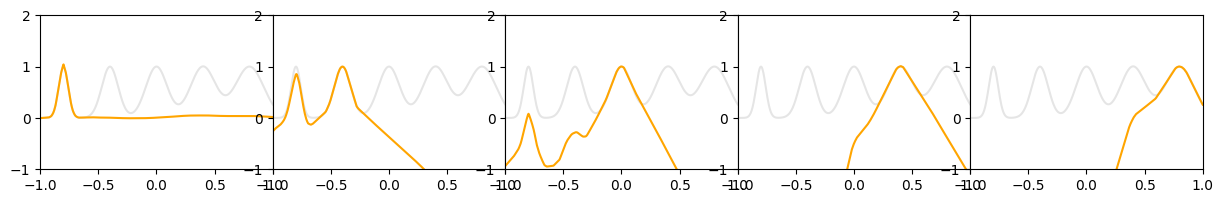

In [12]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    # ys[i-1] = ys[i-1].cpu()
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys[i-1], color='orange')
    plt.xlim(-1,1)
    plt.ylim(-1,2)

plt.savefig('/home/thealch3mist/University/Thesis/KANT_Forget/Figures/test.png')